<a href="https://colab.research.google.com/github/viswakimi/PowerPulse/blob/main/POWERPULSE_Household_Energy_Usage_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PowerPulse: Household Energy Usage Forecast

## Data Understanding & Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

## 1. Load and explore the dataset to understand its structure, variables, and quality.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
file_path = "/content/drive/MyDrive/guvii/projects dataset/household_power_consumption.txt"
data = pd.read_csv(file_path, sep=';', low_memory=False,na_values=["?"], parse_dates={"datetime": ["Date", "Time"]}, infer_datetime_format=True)

Loads the dataset from the specified file_path.
Uses sep=';' because the dataset is separated by semicolons (;).
Handles missing values (na_values=["?"]).
Combines the "Date" and "Time" columns into a single "datetime" column.
Uses infer_datetime_format=True to automatically detect date formats.

## 2. Perform exploratory data analysis (EDA) to identify patterns, correlations, and outliers

In [ ]:
data1=data.copy()

In [ ]:
#  prints the first 5 rows of the dataset to see the structure of the data.
data1.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# Checking Column Info
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


Displays information about the dataset, including column names, data types, and the number of non-null values.
Helps us identify missing values and incorrect data types

In [ ]:
data1.shape

(2075259, 8)

# Data Preprocessing:

## 3.Handle missing or inconsistent data

In [ ]:
# Checking for Missing Data
data1.isnull().sum()

,0
datetime,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


OBSERVATION

Since Data have 25,979 missing rows, it was time series data so best method was

**Forward Fill (Best for Time-Series)**

✅ Uses the last known valid value

✅ Works well if data is continuous and missing values are in blocks

# Best Approach?

If missing values are in long gaps → Forward Fill (ffill)

If missing values are scattered randomly → Mean/Median

If you expect gradual change → Interpolation

In [ ]:
missing_data = data1[data1.isnull().any(axis=1)]
print(missing_data)
# Filters and prints all rows that contain at least one missing value.Helps us understand where data gaps exist.

                   datetime  Global_active_power  Global_reactive_power  \
6839    2006-12-21 11:23:00                  NaN                    NaN   
6840    2006-12-21 11:24:00                  NaN                    NaN   
19724   2006-12-30 10:08:00                  NaN                    NaN   
19725   2006-12-30 10:09:00                  NaN                    NaN   
41832   2007-01-14 18:36:00                  NaN                    NaN   
...                     ...                  ...                    ...   
1990185 2010-09-28 19:09:00                  NaN                    NaN   
1990186 2010-09-28 19:10:00                  NaN                    NaN   
1990187 2010-09-28 19:11:00                  NaN                    NaN   
1990188 2010-09-28 19:12:00                  NaN                    NaN   
2027411 2010-10-24 15:35:00                  NaN                    NaN   

         Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
6839         NaN             

missing values appear in random time intervals rather than continuous blocks. This means a single imputation method may not be optimal. Instead, a combination of techniques will work best.

Best Strategy for our Data

Forward Fill (ffill) – Works for short gaps.

Backward Fill (bfill) – Fills remaining missing values.

Interpolation (linear) – For gradual trends.

 **Method to Use?**

If gaps are small (few minutes to hours) → Use ffill() + bfill() + interpolate()

If gaps are large (days/weeks) → Mean/Median Imputation

In [ ]:
# Filling Missing Values Using Forward Fill
data1.fillna(method='ffill', inplace=True)

Works well for time-series data, where the previous reading is usually a good estimate for the missing one.

## 4.  Data Statistics & Outlier Detection

In [ ]:
data1.isnull().sum()

,0
datetime,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


Returns key statistics like mean, median, min, max, and standard deviation for each numerical column.
Helps understand the range and distribution of the data.

In [ ]:
data1.describe()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,2008-12-06 07:12:59.999994112,1.086168e+00,1.233280e-01,2.408416e+02,4.604226e+00,1.110995e+00,1.287958e+00,6.416570e+00
min,2006-12-16 17:24:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2007-12-12 00:18:30,3.080000e-01,4.800000e-02,2.390000e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008-12-06 07:13:00,5.980000e-01,1.000000e-01,2.410200e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2009-12-01 14:07:30,1.524000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,2010-11-26 21:02:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01
std,NaN,1.053172e+00,1.125144e-01,3.235574e+00,4.426775e+00,6.115908e+00,5.786865e+00,8.419505e+00


OBSERVATION

Outliers:

Columns like Sub_metering_1 and Sub_metering_2 have very high maximum values compared to their 75th percentiles, suggesting the presence of outliers.

Global_intensity also has a high maximum value (48.4) compared to its 75th percentile (6.4), indicating potential outliers.

Zero Values:

Columns like Sub_metering_1 and Sub_metering_2 have a significant number of zero values (25th, 50th, and 75th percentiles are 0.0), which might represent periods of no activity.

In [ ]:
df= data1

## 5. Checks for the Outlier using Box Plot and Histogram visualization

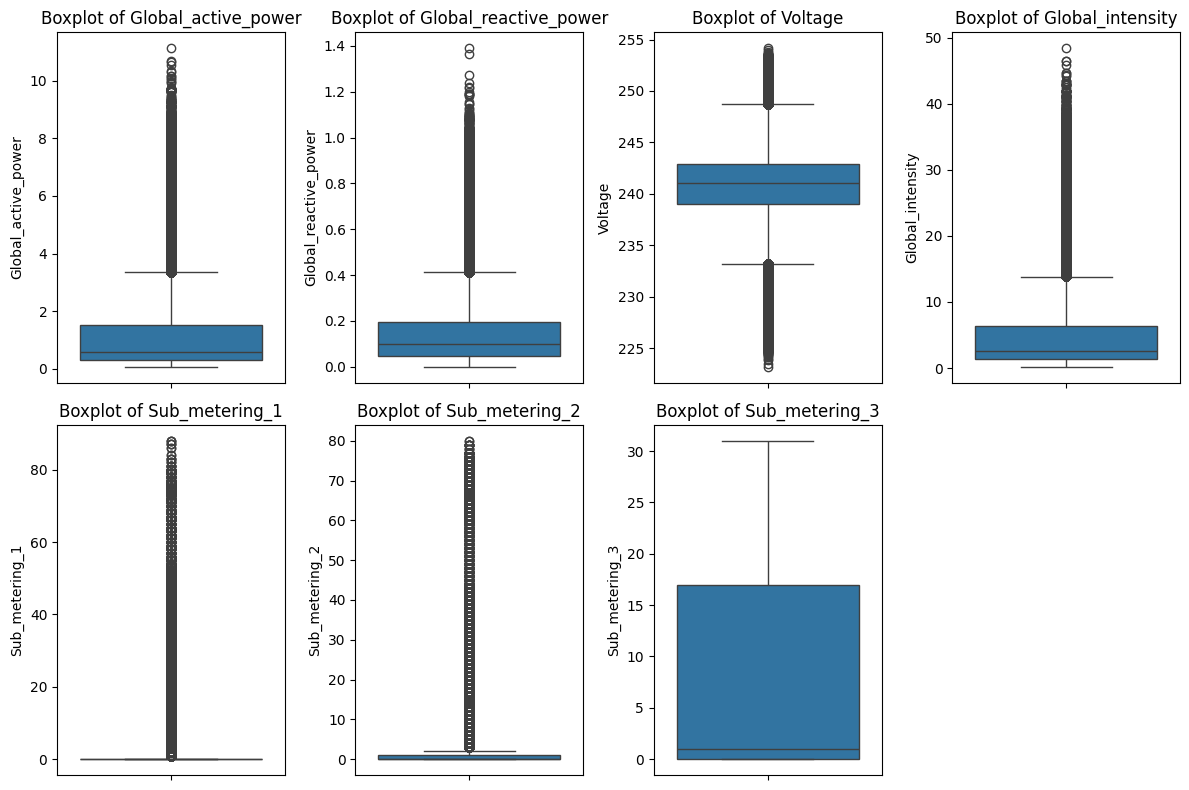

In [ ]:
# Plots boxplots to detect outliers for each feature.
numeric_columns = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(12,8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)  # Create a subplot for each variable
    sns.boxplot(data[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()


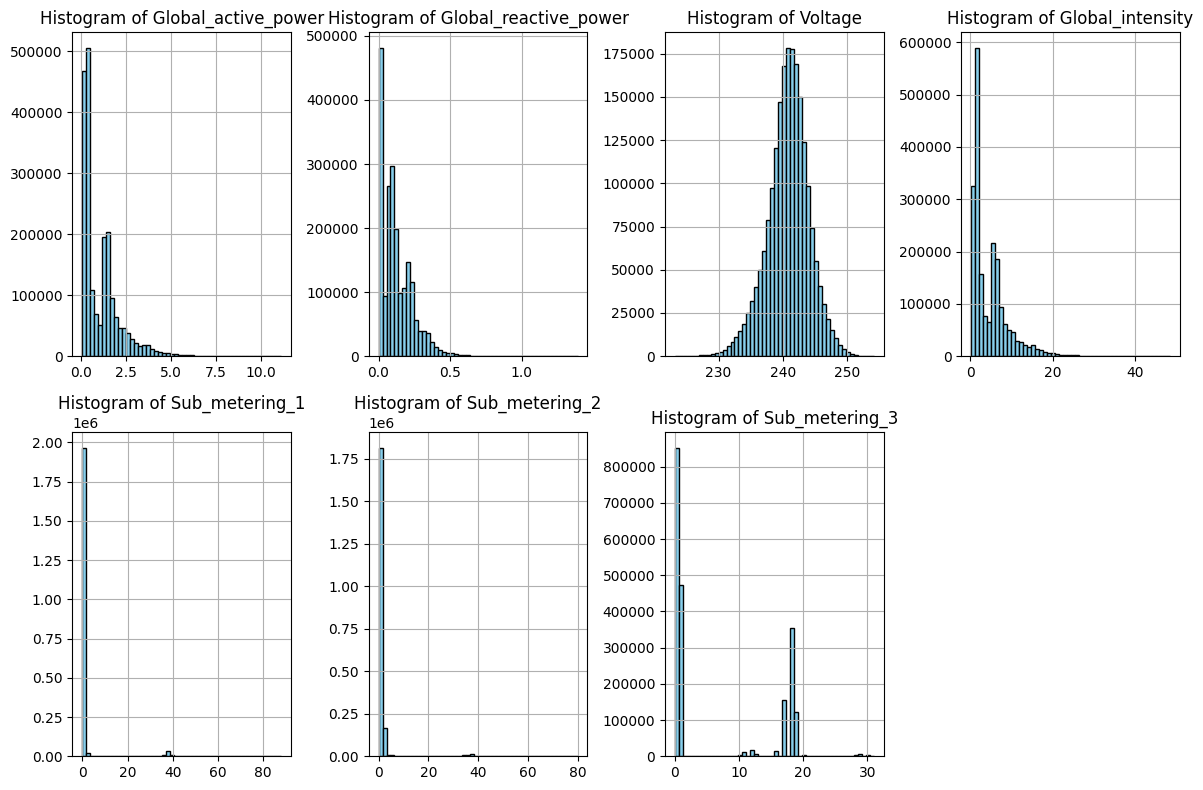

In [ ]:
# Creates histograms for all numerical columns to visualize the data distribution to understand if the data is normally distributed or skewed

numeric_columns = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)  # Create a subplot for each variable
    data[column].hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
plt.tight_layout()
plt.show()

OBSERVATION

histograms and boxplots show the distribution and potential outliers dataset.

** Here are some key observations:**


Global_active_power & Global_intensity:

The histograms suggest a multimodal distribution.
The boxplots indicate some potential outliers.

Global_reactive_power:

The distribution is skewed with a concentration of values near zero.
The boxplot suggests a right-skewed distribution.

Voltage:

The histogram looks normally distributed, but the scale seems unusual (e.g., large numbers).
The boxplot shows some extreme values at both ends.

Sub_metering variables:

The histograms for Sub_metering_1 and Sub_metering_2 suggest most values are concentrated around zero.
Sub_metering_3 has more spread-out values.
The boxplots highlight possible outliers.

In [ ]:
# Calculates skewness for all numerical columns
df.select_dtypes(include=['number']).skew()

,0
Global_active_power,1.797454
Global_reactive_power,1.265232
Voltage,-0.323726
Global_intensity,1.860937
Sub_metering_1,5.983578
Sub_metering_2,7.135711
Sub_metering_3,0.736887


OBSERVATION
If skewness is high (>1 or <-1), the data is highly skewed and might need transformation


**Key Observations**
Skewness:

Most columns (Global_active_power, Global_reactive_power, Global_intensity, Sub_metering_1, Sub_metering_2) are highly positively skewed, indicating the presence of outliers or extreme values.

Voltage is slightly negatively skewed, while Sub_metering_3 is moderately positively skewed.



# Potential Causes of Outliers:

Outliers in power-related columns (Global_active_power, Global_reactive_power, Global_intensity) could be due to sudden spikes in energy usage.

Outliers in sub-metering columns (Sub_metering_1, Sub_metering_2) might represent unusual appliance usage patterns.

In [ ]:
# Understanding Unique Values in a Column
print("\nUnique Values in Sub_metering_1:", df['Sub_metering_1'].nunique())
print("\nValue Counts:")
print(df['Sub_metering_1'].value_counts().head(10))


Unique Values in Sub_metering_1: 88

Value Counts:
Sub_metering_1
0.0     1903013
1.0       84939
2.0       22150
38.0      16121
37.0      14893
39.0       6504
36.0       5270
35.0       1359
40.0       1159
32.0        802
Name: count, dtype: int64


**OBSERVATION:**

Prints the number of unique values in Sub_metering_1.
Displays the top 10 most common values in the column.

Why?

Helps us understand how many different categories exist in this column.

Sub_metering_1, Sub_metering_2, and Sub_metering_3 are highly zero-dominated (a large portion of the values are 0.0).
Their distributions look more categorical/discrete than continuous.
Extreme imbalance: Some values (e.g., 38.0, 37.0, etc.) appear frequently, while others are rare.

Transformations won’t be very effective due to the large presence of zeros.

# Feature Engineering: Extract date-time features

## 6. Parse date and time into separate features**

In [ ]:
# Creating Time-Based Features
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.weekday


Extracts year, month, day, hour, and weekday from the datetime column.These features help the model capture seasonal patterns in energy consumption.

In [ ]:
df["weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# Create additional features

## 7. Creating New Features such as daily averages, peak hours, or rolling averages

In [ ]:
df["daily_avg_power"] = df.groupby(df["datetime"].dt.date)["Global_active_power"].transform("mean")
df["peak_hour"] = df["hour"].apply(lambda x: 1 if 17 <= x <= 21 else 0)
df["rolling_avg_power"] = df["Global_active_power"].rolling(window=60, min_periods=1).mean()


daily_avg_power → Calculates daily average power consumption.
peak_hour → Marks peak energy hours (5 PM to 9 PM) as 1, otherwise 0.
rolling_avg_power → Computes a moving average over a 60-minute window.

# Visualization of energy trends

## 8. Visualizing Yearly Trends

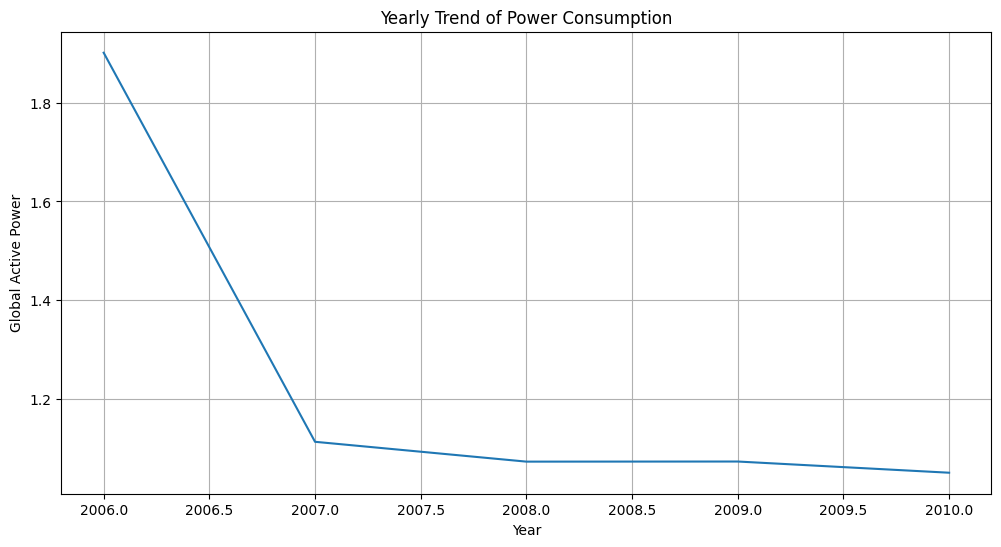

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='Global_active_power', estimator='mean', ci=None)
plt.title("Yearly Trend of Power Consumption")
plt.xlabel("Year")
plt.ylabel("Global Active Power")
plt.grid()
plt.show()

OBSERVATION
 Plots a line graph showing the average energy consumption per year.Helps identify long-term trends in power usage.

 graph shows a consistent decrease in power consumption from 2006 to 2010 and decline could be due to factors like energy efficiency improvements, changes in household behaviors, or external economic influences

## 9. Visualizing Monthly Patterns

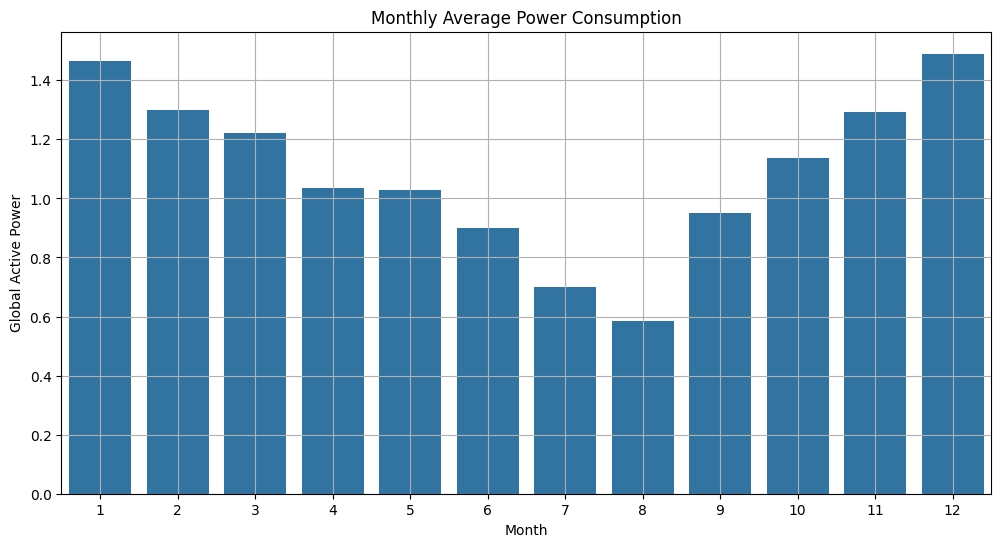

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='month', y='Global_active_power', estimator='mean', ci=None)
plt.title("Monthly Average Power Consumption")
plt.xlabel("Month")
plt.ylabel("Global Active Power")
plt.grid()
plt.show()

# Observations:

Creates a bar plot showing the average power usage per month.
Helps see if there are seasonal changes in power consumption.

***Winter Peak (January & December):***

Power consumption is highest in January and December, indicating increased usage, likely due to heating needs.

***Summer Dip (June to August):***

Consumption is lowest in July and August, suggesting reduced electricity usage, possibly due to less heating demand.

***Gradual Increase from September to December:***
After the summer dip, power usage starts increasing steadily from September onward.

***Symmetry in Seasonal Trends:***

The trend follows a U-shaped pattern, where consumption is higher in colder months and lower in warmer months.

***Possible Explanations:***

Heating appliances in winter lead to increased power consumption.

Lower energy needs in summer due to reduced heating and possibly higher outdoor activities.

Transitional seasons (Spring & Autumn) have moderate consumption.

This seasonal variation is useful for forecasting energy demand and optimizing power distribution.

## 10. Week-wise Power Consumption Trend

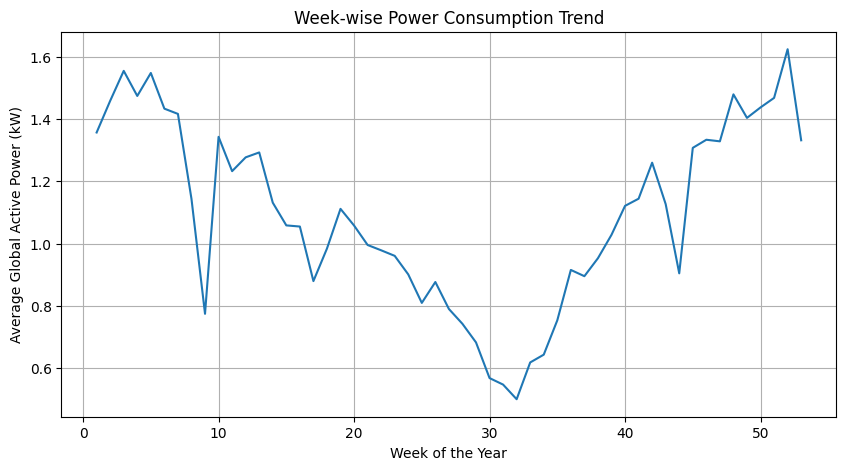

In [ ]:
weekly_trend = df.groupby(df["datetime"].dt.isocalendar().week)["Global_active_power"].mean()
plt.figure(figsize=(10, 5))
weekly_trend.plot(kind="line", title="Week-wise Power Consumption Trend")
plt.xlabel("Week of the Year")
plt.ylabel("Average Global Active Power (kW)")
plt.grid()
plt.show()

**key observations **

Groups power consumption by week and calculates the average power usage.
Plots a line chart to see weekly power consumption patterns.
Helps identify high-usage weeks in the year.


Fluctuations in Consumption: There are significant fluctuations in power consumption throughout the year, with notable peaks and drops.

Early-Year Peak & Mid-Year Dip: Power consumption is relatively high at the beginning, reaching its peak within the first few weeks, followed by a sharp decline around week 10.

Mid-Year Low Point: The lowest consumption levels occur between weeks 25–30.

Gradual Recovery & Late-Year Peaks: After the mid-year dip, power usage increases steadily, with noticeable peaks around weeks 40 and 50.

Seasonal Influence: The trend suggests possible seasonal variations in energy consumption, potentially due to weather changes affecting heating or cooling needs.

## 11.Daily Trend Analysis

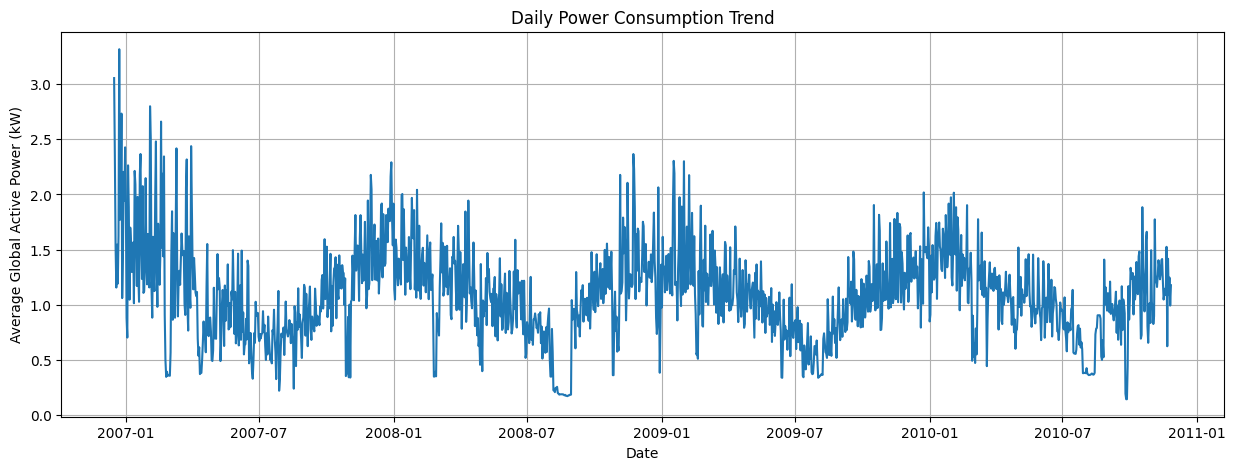

In [ ]:
daily_trend = df.groupby(df["datetime"].dt.date)["Global_active_power"].mean()
plt.figure(figsize=(15, 5))
daily_trend.plot(kind="line", title="Daily Power Consumption Trend")
plt.xlabel("Date")
plt.ylabel("Average Global Active Power (kW)")
plt.grid()
plt.show()

**Key observations from the Daily Power Consumption Trend plot:**

Groups power usage by date and calculates the daily average.
Plots a line chart to visualize daily variations in power consumption.

Overall Declining Trend (2007–2010): The power consumption appears to decrease gradually over time, with some fluctuations.

High Initial Consumption (Early 2007): There is a significant peak in power consumption at the beginning of the dataset, with values exceeding 3.0 kW.

Seasonal or Cyclical Patterns: The data shows periodic rises and falls, possibly indicating seasonal variations or external influencing factors.

Mid-2008 to Mid-2009 Dip: A notable low in power consumption occurs during this period, followed by a gradual increase again.

Fluctuations in Late 2010: Towards the end of the dataset, there are increased variations in power usage, suggesting potential seasonal or behavioral influences.

## 12.Hourly Power Consumption Trends

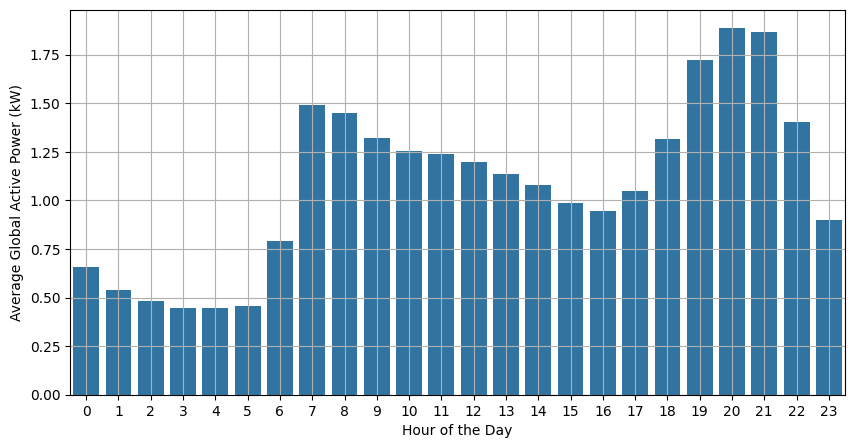

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='hour', y='Global_active_power', estimator='mean', ci=None)
plt.xlabel("Hour of the Day")
plt.ylabel("Average Global Active Power (kW)")
plt.grid()
plt.show()

**Key observations from the Hourly Power Consumption Trend plot:**

Creates a bar plot showing power consumption by hour of the day.
Helps identify peak energy hours

Lowest Consumption (Midnight to Early Morning, 0–6 AM): Power usage is at its lowest during these hours, likely due to minimal household activity.

Morning Surge (7–9 AM): There is a sharp increase in power consumption, probably due to morning routines like cooking, heating, and appliance usage.

Daytime Stability (10 AM – 4 PM): Power consumption remains relatively stable but slightly decreases during the afternoon.

Evening Peak (6–9 PM): The highest power usage occurs in the evening, with a peak around 8–9 PM, likely due to increased household activity such as cooking, lighting, and entertainment.

Decline After 9 PM: Consumption gradually decreases after the peak, but it remains higher than early morning levels.

## 13.Weekday vs. Weekend Power Consumption

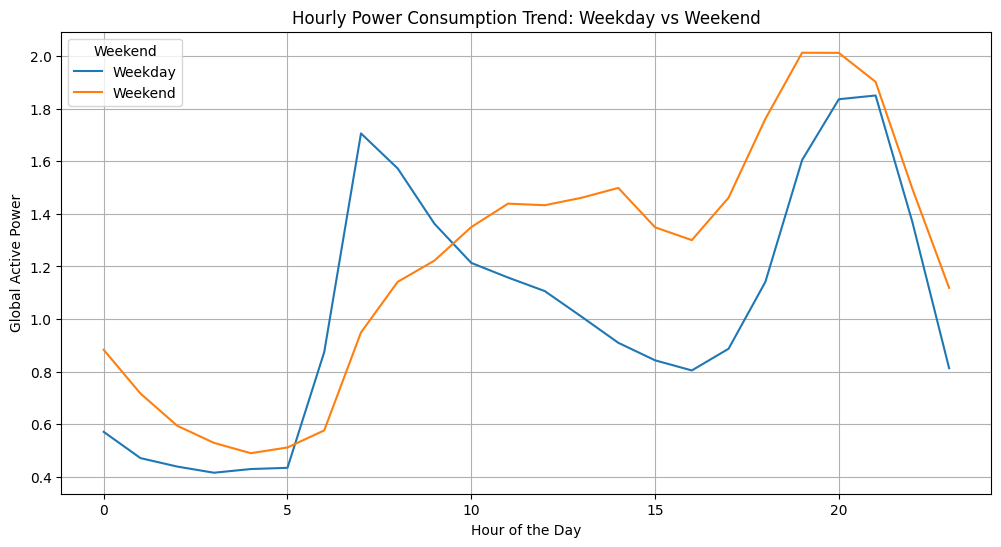

In [ ]:
# Compare weekday vs weekend power consumption with line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='Global_active_power', hue='weekend', estimator='mean', ci=None)
plt.title("Hourly Power Consumption Trend: Weekday vs Weekend")
plt.xlabel("Hour of the Day")
plt.ylabel("Global Active Power")
plt.legend(title="Weekend", labels=["Weekday", "Weekend"])
plt.grid()
plt.show()

Key observations from the Power Consumption Trend: Weekday vs Weekend plot:

ompares hourly power usage trends between weekdays and weekends.
Helps understand if weekend energy usage is different

Weekday Early Morning Dip (0–5 AM): Power consumption is lower during early morning hours on weekdays compared to weekends, likely because people wake up later on weekends.

Sharp Weekday Morning Spike (6–9 AM): There is a steep increase in power usage during weekday mornings, likely due to early morning routines before work and school.
Steady Weekend Increase (6 AM – 12 PM): Unlike weekdays, weekends show a more gradual rise in power usage throughout the morning, indicating a slower start to the day.

Afternoon Decline on Weekdays (12–17 PM): Power consumption steadily decreases during work hours on weekdays, while it remains relatively stable on weekends.

Evening Peak (18–21 PM): Both weekdays and weekends exhibit peak power consumption in the evening, but the weekend peak is slightly higher, possibly due to more at-home activities like entertainment and cooking.

Faster Decline After 9 PM on Weekdays: Weekday consumption drops sharply after 9 PM, while weekend usage remains elevated for a longer period before gradually declining.

### Dropping the datetime Column Before Training

In [ ]:
df.drop(columns=["datetime"], inplace=True)

## 14. Feature Importance Visualization-correlation heatmaps and pair plots

Heatmap: Highlights correlations between Global Active Power and other features.

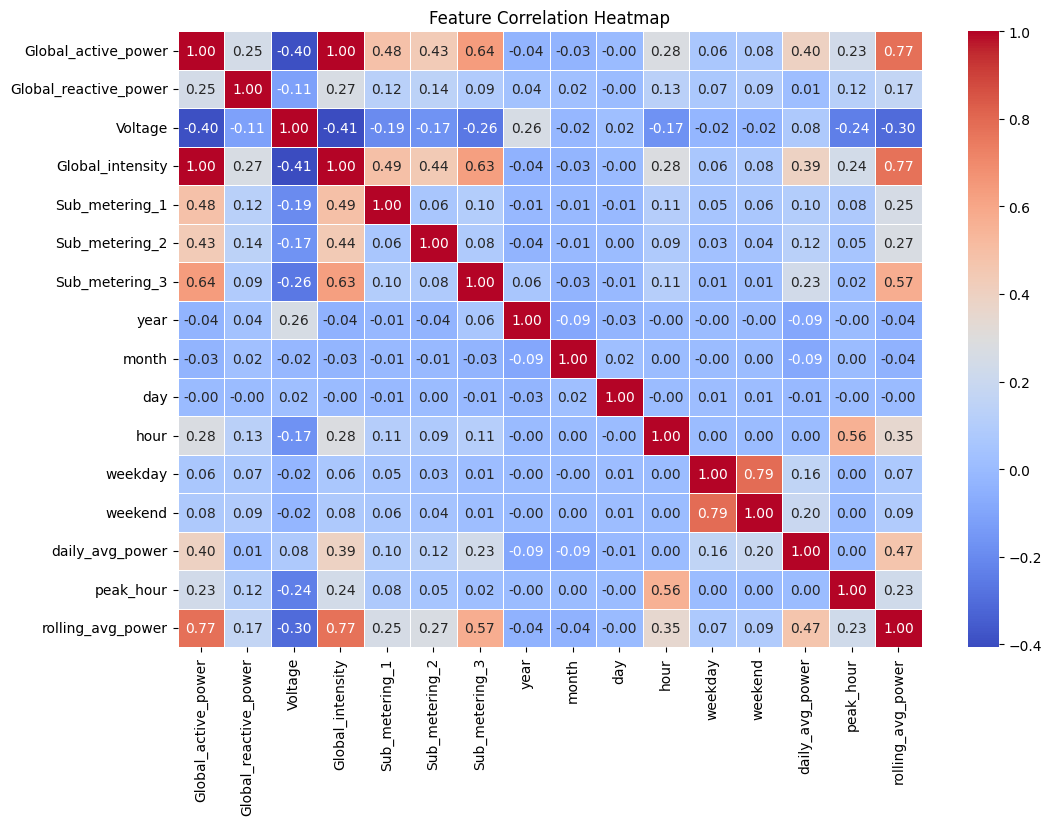

In [ ]:
# Correlation heatmap to identify which features are most strongly related to power consumption.
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


OBSERVATION:

**Strong Correlation with Global Active Power:**

Global Intensity (0.64): This makes sense as power consumption is directly related to current.
Sub_metering_3 (0.64): Indicates that this sub-metered area contributes significantly to overall power usage.
Rolling Average Power (0.33) & Daily Average Power (0.40): These engineered features show some relationship with Global Active Power.

**Negative Correlation:**

Voltage (-0.40): A notable inverse relationship, indicating that higher voltages might be associated with lower power consumption.

**Temporal Features:**

Hour (0.28): Suggests that power usage fluctuates based on time of day.
Peak Hour (0.23): Confirms that consumption increases during peak usage periods.

**Weak or No Correlation:**

Year, Month, Day, and Weekday have very weak correlation, implying seasonal variations may not have a strong direct impact on short-term power fluctuations.

## 15.Feature Selection Using Mutual Information

In [ ]:
from sklearn.feature_selection import mutual_info_regression

Calculates Mutual Information Scores to measure how much each feature influences power consumption.
Sorts the most important features

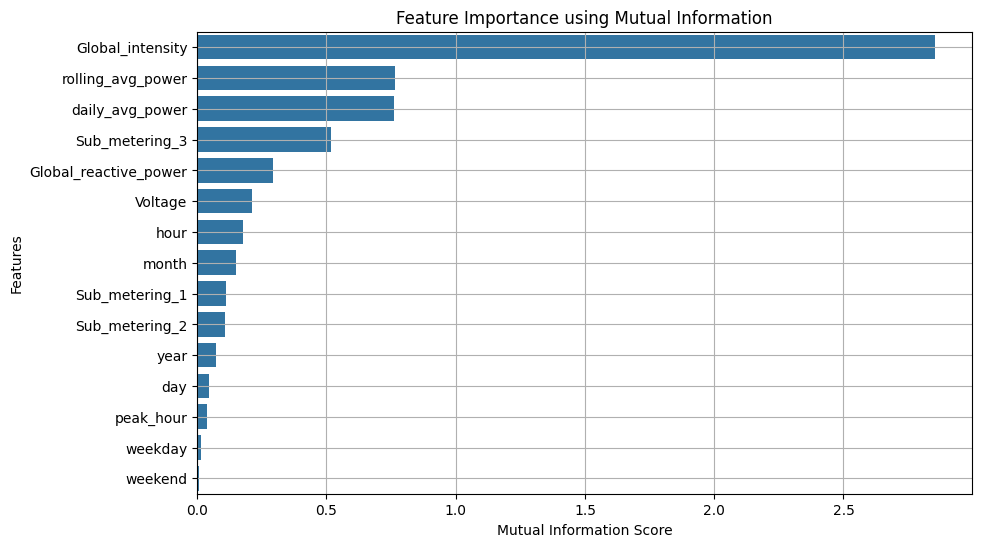

In [ ]:
# Mutual Information for Feature Selection
X = df.drop(columns=["Global_active_power"])
y = df["Global_active_power"]
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores, y=mi_scores.index)
plt.title("Feature Importance using Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.grid()
plt.show()

OBSERVATION from Feature Selection:

Global Intensity Dominates

The Global_intensity feature has the highest mutual information score, indicating a strong relationship with Global_active_power. This suggests that current intensity is a major predictor of power consumption.
Daily and Rolling Averages are Significant

daily_avg_power and rolling_avg_power contribute significantly, meaning that past consumption patterns influence future power usage.


Sub-metering and Reactive Power Contribute Moderately

Sub_metering_3, Sub_metering_1, Sub_metering_2, and Global_reactive_power show some relevance but are not the top predictors.

Time-Based Features Matter

Features like hour, month, and weekday contribute, though with lower scores. This suggests that power usage varies with time but is not the strongest determinant.

Weekend and Peak Hour Effects are Minimal

weekend and peak_hour have negligible influence, meaning power consumption patterns may not change significantly between weekdays and weekends.

## 16. Define target variable and feature

In [ ]:
# Selecting Features for Model Training
x = df[["Global_intensity",'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3' ,'Voltage']]
y = df["Global_active_power"]

Using only the most relevant features helps improve model accuracy.

# Model Selection and Training:

## 17 .Splitting Data into Training & Testing Sets

In [ ]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

Splits the dataset into training (70%) and testing (30%) sets.
Helps train the model on one part of the data and test it on unseen data.

## 18 .Feature Scaling for Neural Networks

In [ ]:
# Normalize features for neural networks only
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Standardizes the features by converting them to zero mean and unit variance.
Neural networks work better with scaled data, preventing large values from dominating smaller ones.tree-based models (RandomForest, GradientBoosting) do not require scaling

# Train regression models

## 19. Defining Machine Learning Models

In [ ]:
# Define models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=30),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=30),
    "NeuralNetwork": MLPRegressor(random_state=30, max_iter=200)
}

Defines four different regression models:
Linear Regression (Baseline Model).
Random Forest Regressor (Tree-based model for capturing non-linear patterns).
Gradient Boosting Regressor (Boosting model for better accuracy).
Neural Network (MLP Regressor) (Deep learning approach).

## 20.Training Models (Before Hyperparameter Tuning)

In [ ]:
# Train models before hyperparameter tuning
trained_models = {}
for name, model in models.items():
    if name == "NeuralNetwork":
        model.fit(x_train_scaled, y_train)
    else:
        model.fit(x_train, y_train)
    trained_models[name] = model

Trains all models on the training data.
If the model is a neural network, it uses scaled data (x_train_scaled).
Stores the trained models in trained_models.

## 21. Model Evaluation Function

In [ ]:
# Evaluate models before hyperparameter tuning
def evaluate_model(model, x_test, y_test, scaled=False):
    if scaled:
        y_pred = model.predict(x_test_scaled)
    else:
        y_pred = model.predict(x_test)
    return {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R-squared": r2_score(y_test, y_pred)
    }


Defines a function to evaluate models using:
Root Mean Squared Error (RMSE) → Measures model error.
Mean Absolute Error (MAE) → Average absolute error.
R-squared (R²) → How well the model explains variance.
Uses scaled data for neural networks.

## 22.  Evaluating Models Before Tuning

In [ ]:
# Runs the evaluation function on all models.
evaluations_before_tuning = {name: evaluate_model(model, x_test, y_test, scaled=(name == "NeuralNetwork")) for name, model in trained_models.items()}
print("Evaluation Before Hyperparameter Tuning:", evaluations_before_tuning)

Evaluation Before Hyperparameter Tuning: {'LinearRegression': {'RMSE': 0.044376853264235974, 'MAE': 0.029539562263289333, 'R-squared': 0.9982189710188145}, 'RandomForestRegressor': {'RMSE': 0.03867669163093655, 'MAE': 0.02351046127693358, 'R-squared': 0.9986471282901616}, 'GradientBoostingRegressor': {'RMSE': 0.037172312786398674, 'MAE': 0.024106097390248542, 'R-squared': 0.9987503248171723}, 'NeuralNetwork': {'RMSE': 0.035468260982032526, 'MAE': 0.022881228557203058, 'R-squared': 0.9988622737708825}}


In [ ]:
# Prints the metrics for each model.Displaying Model Performance
print("Evaluation Before Hyperparameter Tuning:")
for model_name, metrics in evaluations_before_tuning.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Evaluation Before Hyperparameter Tuning:

Model: LinearRegression
  RMSE: 0.0444
  MAE: 0.0295
  R-squared: 0.9982

Model: RandomForestRegressor
  RMSE: 0.0387
  MAE: 0.0235
  R-squared: 0.9986

Model: GradientBoostingRegressor
  RMSE: 0.0372
  MAE: 0.0241
  R-squared: 0.9988

Model: NeuralNetwork
  RMSE: 0.0355
  MAE: 0.0229
  R-squared: 0.9989


## 23.Perform hyperparameter tuning to optimize model performance.

In [ ]:
# Hyperparameter tuning (RandomizedSearchCV for efficiency)
param_grids = {
    "RandomForestRegressor": {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5]},
    "GradientBoostingRegressor": {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    "NeuralNetwork": {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu'], 'alpha': [0.0001]},
}

Defines hyperparameter search spaces for:
Random Forest (n_estimators, max_depth, etc.).
Gradient Boosting (learning_rate, max_depth, etc.).
Neural Network (hidden_layer_sizes, activation, etc.)

## 24. Running Hyperparameter Tuning

In [ ]:
tuned_models = {}
for name, model in trained_models.items():
    if name in param_grids:
        search = RandomizedSearchCV(model, param_grids[name], cv=2, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=5)
        if name == "NeuralNetwork":
            search.fit(x_train_scaled, y_train)
        else:
            search.fit(x_train, y_train)
        tuned_models[name] = search.best_estimator_
    else:
        tuned_models[name] = model

Uses RandomizedSearchCV (more efficient than GridSearchCV) to find the best hyperparameters.
Cross-validates (cv=2) to prevent overfitting.
Stores optimized models in tuned_models.

## 25. Evaluate models using appropriate metrics (e.g., RMSE, MAE, R-squared).

In [ ]:
# Evaluate models after hyperparameter tuning
evaluations_after_tuning = {name: evaluate_model(model, x_test, y_test, scaled=(name == "NeuralNetwork")) for name, model in tuned_models.items()}
print("Evaluation After Hyperparameter Tuning:", evaluations_after_tuning)


Evaluation After Hyperparameter Tuning: {'LinearRegression': {'RMSE': 0.044376853264235974, 'MAE': 0.029539562263289333, 'R-squared': 0.9982189710188145}, 'RandomForestRegressor': {'RMSE': 0.0372999238706028, 'MAE': 0.023287453837768736, 'R-squared': 0.998741729918214}, 'GradientBoostingRegressor': {'RMSE': 0.0368973980159076, 'MAE': 0.02401183241459282, 'R-squared': 0.9987687408763826}, 'NeuralNetwork': {'RMSE': 0.035468260982032526, 'MAE': 0.022881228557203058, 'R-squared': 0.9988622737708825}}


### Displaying Model Performance After Tuning

In [ ]:
print("Evaluation After Hyperparameter Tuning:")
for name, metrics in evaluations_after_tuning.items():
    print(f"\nModel: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Evaluation After Hyperparameter Tuning:

Model: LinearRegression
RMSE: 0.0444
MAE: 0.0295
R-squared: 0.9982

Model: RandomForestRegressor
RMSE: 0.0373
MAE: 0.0233
R-squared: 0.9987

Model: GradientBoostingRegressor
RMSE: 0.0369
MAE: 0.0240
R-squared: 0.9988

Model: NeuralNetwork
RMSE: 0.0355
MAE: 0.0229
R-squared: 0.9989


Key Observations After Hyperparameter Tuning:
All models exhibit extremely high performance, with R² values above 0.998, indicating that they explain nearly all variance in power consumption.
Neural Network performs the best, achieving the lowest RMSE (0.0355) and MAE (0.0229), suggesting it makes the most accurate predictions overall.
Gradient Boosting Regressor and Random Forest Regressor also perform exceptionally well, with slightly higher RMSE and MAE compared to the Neural Network.

## 26 .Compare model performance and select the best-performing model.

In [ ]:
# Identify the best model based on highest R-squared
best_model_name = max(evaluations_after_tuning, key=lambda k: evaluations_after_tuning[k]["R-squared"])
best_model_metrics = evaluations_after_tuning[best_model_name]

# Display the best model
print("\nBest Model:")
print(f"Model: {best_model_name}")
for metric, value in best_model_metrics.items():
    print(f"  {metric}: {value:.4f}")


Best Model:
Model: NeuralNetwork
  RMSE: 0.0355
  MAE: 0.0229
  R-squared: 0.9989


## 27. Visualization of predictive performance

In [ ]:
# Visualization of predictive performance
predictions = {name: model.predict(x_test_scaled if name == "NeuralNetwork" else x_test) for name, model in tuned_models.items()}

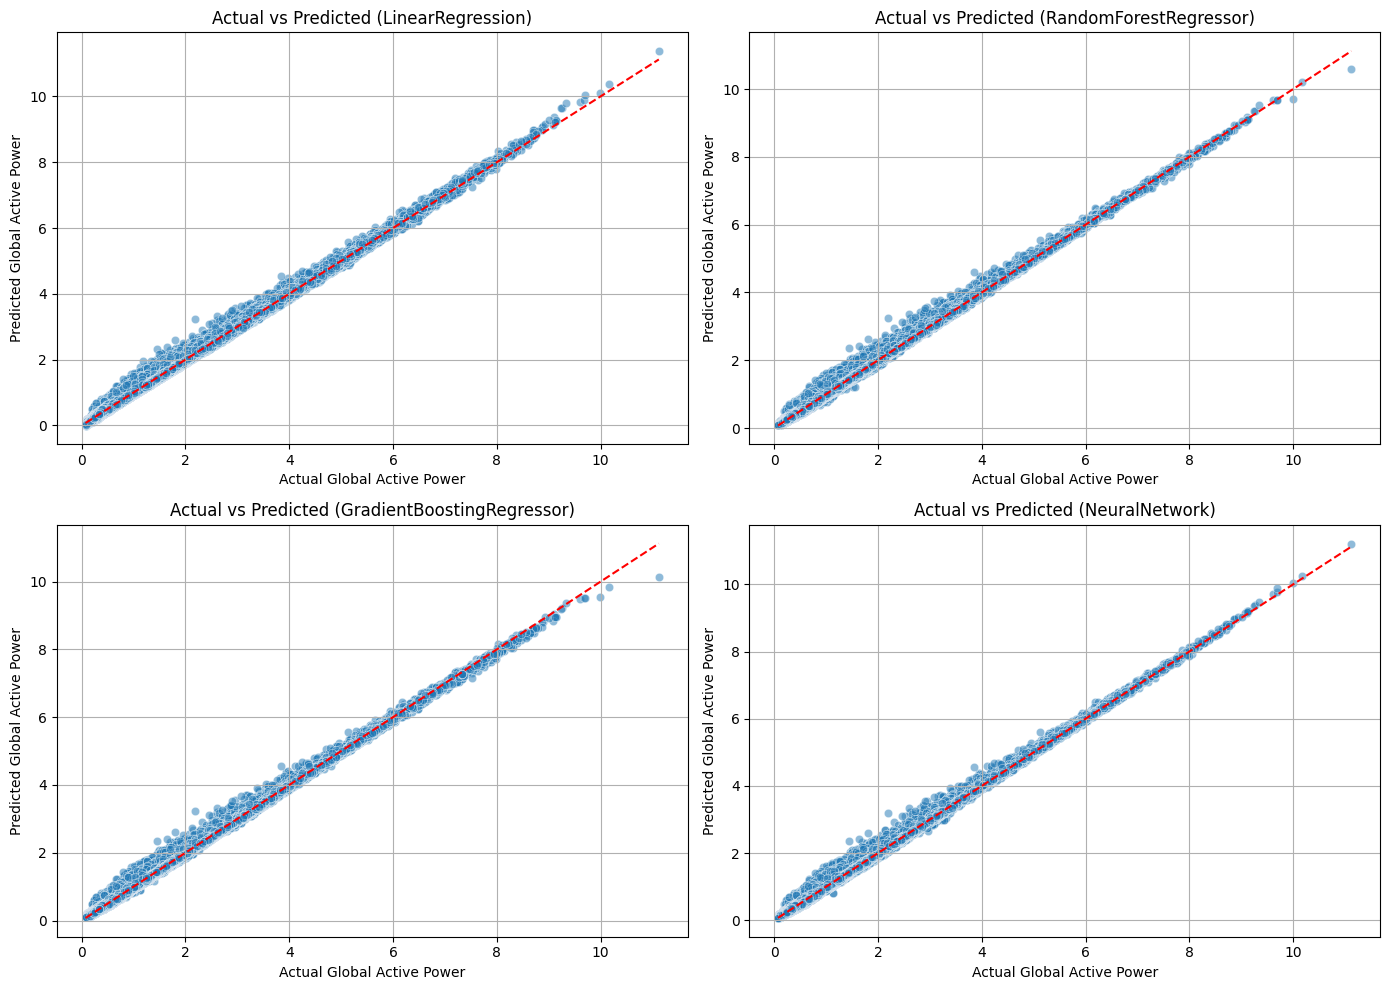

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for (model_name, y_pred), ax in zip(predictions.items(), axes):
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    ax.set_title(f"Actual vs Predicted ({model_name})")
    ax.set_xlabel("Actual Global Active Power")
    ax.set_ylabel("Predicted Global Active Power")
    ax.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Key observations from the Actual vs Predicted scatter plots for different models:

Linear Regression (Top Left):

Predictions closely follow the red diagonal line, but some deviation is observed at higher values.
Performance appears decent, but the model might struggle slightly with non-linearity in the data.
Random Forest Regressor (Top Right):

Predictions are well-aligned with the actual values, showing a strong fit.
Minimal deviation indicates the model captures complex patterns effectively.
Slight underestimation for higher values.
Gradient Boosting Regressor (Bottom Left):

Very close alignment with the actual values, similar to Random Forest.
Small deviations at extreme values, but overall strong predictive performance.
Neural Network (Bottom Right):

Shows the best alignment with the red diagonal, suggesting high accuracy.
Handles higher values well, reducing bias in predictions.
Minimal spread in the scatter points, indicating robustness.

Insights:
Linear Regression performs well but may struggle with non-linearity.

Random Forest and Gradient Boosting provide strong, accurate predictions with slight variations at higher values.

Neural Network appears to be the most accurate, closely matching the actual values across the entire range.